Best tour: [5, 18, 22, 12, 6, 4, 26, 20, 16, 19, 25, 21, 24, 2, 15, 7, 28, 0, 8, 14, 17, 29, 9, 27, 3, 23, 1, 13, 11, 10, 5]
Best cost: 46.73
Total Iterations: 93712
Neighbor Method: two_opt
Execution Time: 1.01 seconds


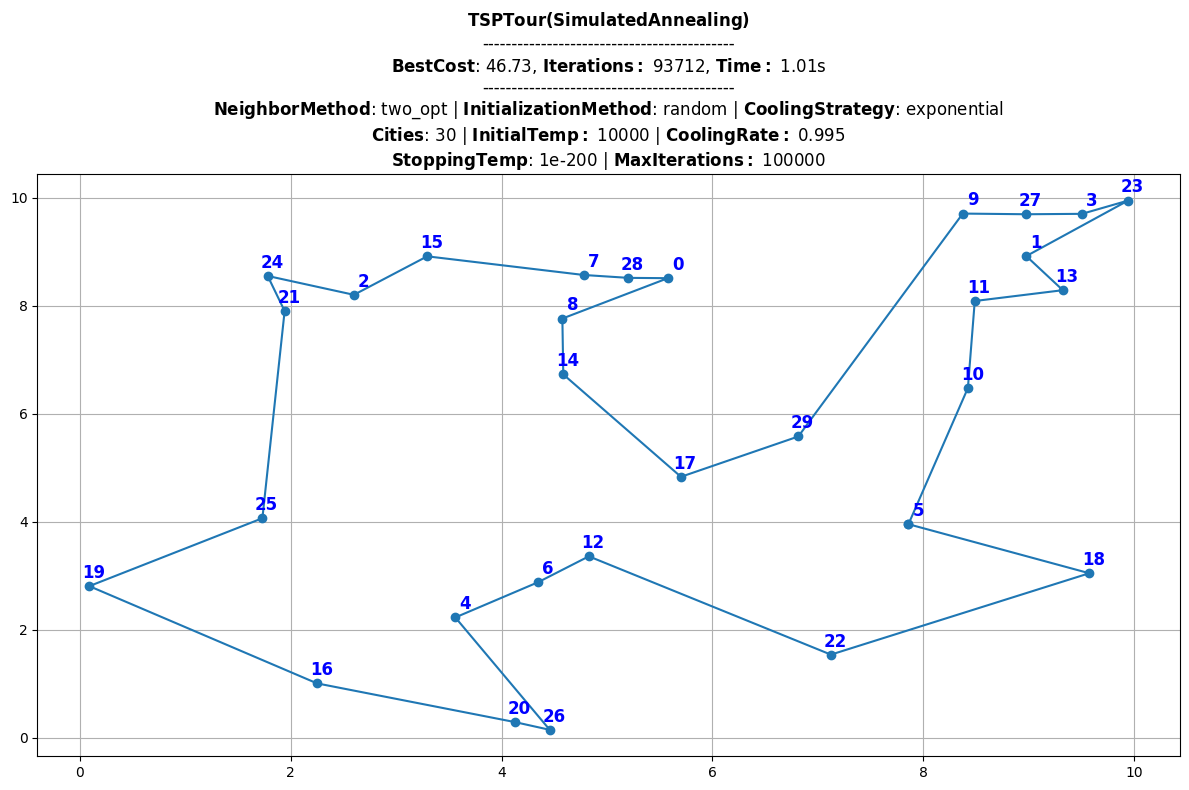

In [2]:
import math
import random
import matplotlib.pyplot as plt
import time


#I. THIẾT LẬP CÁC HÀM SẼ SỬ DỤNG___________________________________________________________________________________________________________________________________
# ---- Khởi tạo các thành phố ở những tọa độ ngẫu nhiên ----
def generate_cities(num_cities):
    return [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(num_cities)]

# ---- Tính toán khoảng cách giữa 2 thành phố ----
def distance(city1, city2):
    return math.hypot(city1[0] - city2[0], city1[1] - city2[1])

# --- Tính tổng quảng đường của chuyến đi ---
def total_distance(tour, cities):
    return sum(distance(cities[tour[i]], cities[tour[(i + 1) % len(tour)]]) for i in range(len(tour)))

# --- Dùng thuật toán nearest neighbor đề tìm lời giải ---
def nearest_neighbor(cities):
    start = 0
    tour = [start]
    unvisited = set(range(len(cities))) - {start}

    while unvisited:
        current = tour[-1]
        next_city = min(unvisited, key=lambda city: distance(cities[current], cities[city]))
        tour.append(next_city)
        unvisited.remove(next_city)

    return tour

#II. CÁC PHƯƠNG THỨC NEIGHBOR___________________________________________________________________________________________________________________________________
# --- 2-opt Swap ---
def two_opt(tour):
    a, b = sorted(random.sample(range(len(tour)), 2))
    new_tour = tour[:a] + tour[a:b+1][::-1] + tour[b+1:]
    return new_tour

# --- 3-opt Swap ---
def three_opt(tour, cities):
    a, b, c = sorted(random.sample(range(len(tour)), 3))
    
    # Các lựa chọn cho 3-opt (bao gồm các cách đảo ngược đoạn)
    choices = [
        tour[:a] + tour[a:b+1] + tour[b+1:c+1] + tour[c+1:],          
        tour[:a] + tour[a:b+1][::-1] + tour[b+1:c+1] + tour[c+1:],    
        tour[:a] + tour[a:b+1] + tour[b+1:c+1][::-1] + tour[c+1:],    
        tour[:a] + tour[a:b+1][::-1] + tour[b+1:c+1][::-1] + tour[c+1:], 
        tour[:a] + tour[b+1:c+1] + tour[a:b+1] + tour[c+1:],          
        tour[:a] + tour[b+1:c+1][::-1] + tour[a:b+1] + tour[c+1:],    
        tour[:a] + tour[b+1:c+1] + tour[a:b+1][::-1] + tour[c+1:],    
        tour[:a] + tour[b+1:c+1][::-1] + tour[a:b+1][::-1] + tour[c+1:] 
    ]
    
    # Chọn lựa chọn tối ưu nhất trong số các lựa chọn 3-opt
    new_tour = min(choices, key=lambda t: total_distance(t, cities))

    return new_tour

# --- Random Swap ---
def random_swap(tour):
    a, b = random.sample(range(len(tour)), 2)
    tour[a], tour[b] = tour[b], tour[a]
    
    return tour


#III. HÀM CHÍNH______________________________________________________________________________________________________________________________________________

# ---- Simulated Annealing Algorithm ----
def simulated_annealing(num_cities, initial_temp, cooling_rate, stopping_temp, max_iter, neighbor_method=None, 
                        initialization_method = None, cooling_strategy = None, OnlyNearestNeighbor = False, CustomCity = []):
    
    if CustomCity:
        cities = CustomCity
        num_cities = len(CustomCity)
    else:
        cities = generate_cities(num_cities)

    #Chỉ sử dụng Nearest Neighbor và xuất kết quả. Sử dụng cho mục đích so sánh
    if OnlyNearestNeighbor:
        initialization_method='nn'

    #Chọn phương thức khởi tạo state: Nearest Neighbor hoặc Random
    if initialization_method == 'nn':
        current_tour = nearest_neighbor(cities)
    elif initialization_method =="random":
        current_tour = list(range(num_cities))
        random.shuffle(current_tour)
    

    #------------------------------------------------------------
    current_cost = total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_cost = current_cost
    temp = initial_temp

    iteration_counter = 0
    neighbor_method_name = neighbor_method.__name__  
    #------------------------------------------------------------

    #Chỉ sử dụng Nearest Neighbor và xuất kết quả. Sử dụng cho mục đích so sánh
    if OnlyNearestNeighbor:
        return best_tour, best_cost, cities, iteration_counter, neighbor_method_name=="None", initialization_method

    #Bắt đầu Stimulated Annealing
    for i in range(max_iter):

        iteration_counter += 1

        if temp < stopping_temp:
            break
        
        #Chọn phương thức Neighbor
        if neighbor_method == three_opt:
            new_tour = neighbor_method(current_tour, cities)
        else:
            new_tour = neighbor_method(current_tour) #Random swap hoặc 2-opt

        #------------------------------------------------------------    
        new_cost = total_distance(new_tour, cities)
        delta = new_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_tour = new_tour
            current_cost = new_cost
            if current_cost < best_cost:
                best_tour = current_tour[:]
                best_cost = current_cost
        #------------------------------------------------------------

        #Chọn chiến lược làm lạnh
        if cooling_strategy == 'exponential':
            temp *= cooling_rate
        elif cooling_strategy == 'linear':
            temp -= cooling_rate
        elif cooling_strategy == 'logarithmic':
            temp = initial_temp / (1 + cooling_rate * math.log(1 + iteration_counter))
    
    

    return best_tour, best_cost, cities, iteration_counter, neighbor_method_name, initialization_method

#IV. CHẠY THUẬT TOÁN___________________________________________________________________________________________________________________________________
start_time = time.time() #Đếm thời gian chạy

num_cities = 30
initial_temp = 10000
cooling_rate = 0.995
stopping_temp = 1e-200
max_iter = 100000
neighbor_method=two_opt
initialization_method = "random"
cooling_strategy = 'exponential'
OnlyNearestNeighbor = False
CustomCity = [] #vd: (2, 2), (6, 7), (3, 4), (1, 1), (9 , 4), ( 5, 4)

best_tour, best_cost, cities, iterations, neighbor_name, initialization_name = simulated_annealing(
    num_cities=num_cities,
    initial_temp=initial_temp,
    cooling_rate=cooling_rate,
    stopping_temp=stopping_temp,
    max_iter=max_iter,
    neighbor_method=neighbor_method,
    initialization_method=initialization_method,
    cooling_strategy=cooling_strategy,
    OnlyNearestNeighbor=OnlyNearestNeighbor,
    CustomCity=CustomCity
)

end_time = time.time()  #Đếm thời gian chạy

execution_time = round(end_time - start_time, 2) 

#V. IN KẾT QUẢ___________________________________________________________________________________________________________________________________
print("Best tour:", best_tour+ [best_tour[0]])
print("Best cost:", round(best_cost, 2))
print("Total Iterations:", iterations)
print("Neighbor Method:", neighbor_name)
print("Execution Time:", execution_time, "seconds")

# ---- Mathplot ----
def plot_tour(tour, cities, iterations, num_cities, initial_temp, cooling_rate, stopping_temp, max_iter, neighbor_name,initialization_name, cooling_stategy):
    plt.figure(figsize=(12, 8))  # Tăng kích thước khung hình
    
    tour_cities = [cities[i] for i in tour] + [cities[tour[0]]]
    xs, ys = zip(*tour_cities)
    plt.plot(xs, ys, marker='o')

    for idx, (x, y) in enumerate(cities):
        plt.text(
            x + 0.15, y + 0.15,  # Đẩy số thứ tự ra xa một chút
            str(idx), 
            fontsize=12, 
            ha='right',
            fontweight='bold',
            color='blue' 
        )
   
    if OnlyNearestNeighbor == False:
        plt.title(
            f'$\\mathbf{{TSP Tour (Simulated Annealing)}}$\n-------------------------------------------\n'
            f'$\\mathbf{{Best Cost}}$: {round(best_cost, 2)}, $\\mathbf{{Iterations:}}$ {iterations}, $\\mathbf{{Time:}}$ {execution_time}s \n-------------------------------------------\n'
            f'$\\mathbf{{Neighbor Method}}$: {neighbor_name} | $\\mathbf{{Initialization Method}}$: {initialization_name} | $\\mathbf{{Cooling Strategy}}$: {cooling_stategy}\n'
            f'$\\mathbf{{Cities}}$: {num_cities} | $\\mathbf{{Initial Temp:}}$ {initial_temp} | $\\mathbf{{Cooling Rate:}}$ {cooling_rate}\n'
            f'$\\mathbf{{Stopping Temp}}$: {stopping_temp} | $\\mathbf{{Max Iterations:}}$ {max_iter}',
            fontsize=12, ha='center'
        )
    else:
        plt.title(
            f'$\\mathbf{{OnlyNearestNeighbor}}$\n-------------------------------------------\n'
            f'$\\mathbf{{Best Cost}}$: {round(best_cost, 2)}, $\\mathbf{{Iterations:}}$ {iterations}, $\\mathbf{{Time:}}$ {execution_time}s \n-------------------------------------------\n'
            f'$\\mathbf{{Initialization Method}}$: {initialization_name}'       
        )

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_tour(
    best_tour, cities, iterations, num_cities, 
    initial_temp, cooling_rate, stopping_temp, max_iter, neighbor_name, initialization_method, cooling_strategy
)
